<h1><center> PathLinker Cytoscape automation example </center></h1>
<img src="http://apps.cytoscape.org/media/pathlinker/logo.png.png" alt="PathLinker Logo">

## Requirments
* Java 8
* Cytoscape 3.6.0+
* cyREST 3.6.0+
* py2cytoscape 0.4.2+

## This notebook is based on the following scripts:
* [New_wrapper_api_sample](http://nbviewer.jupyter.org/github/idekerlab/py2cytoscape/blob/master/examples/New_wrapper_api_sample.ipynb)
* [basic1](http://nbviewer.jupyter.org/github/idekerlab/py2cytoscape/blob/master/examples/basic1.ipynb)

In [1]:
# necessary libraries and dependencies
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil

import networkx as nx
import pandas as pd
import json
import requests

In [2]:
# !!!!!!!!!!!!!!!!! Step 0: Start Cytoscape 3.6 with cyREST App !!!!!!!!!!!!!!!!!!!!!!!!!!
# Cytoscape must be running to use the automation features

# Step 1: create an instance of cyRest client
cy = CyRestClient()

# Reset the session
cy.session.delete()

## Create network using networkx

To create a network that PathLinker will run on, the example uses the [background-interactome-pathlinker-2015.txt](https://github.com/Murali-group/PathLinker-Cytoscape/blob/master/src/test/resources/input/graph-dir_human-interactome.txt). <br>
To learn more about the sample file please visit the [PathLinker paper](http://bioinformatics.cs.vt.edu/~murali/supplements/2016-sys-bio-applications-pathlinker/).

In [3]:
# Step 2: Import/Create the network that PathLinker will run on

# Store the sample text file into csv_directory
# Please modify the csv_directory if you want to create network using different text files
csv_directory = 'background-interactome-pathlinker-2015.txt'

# create a new network by importing the data from a sample using pandas
network_csv = pd.read_csv(csv_directory, header=None, sep='\t', lineterminator='\n')

# initialize an empty graph from networkx
nx_network = nx.Graph()

# fill the empty network with source, target, and corresponding edge weight
# from the data inside the network_csv
for row in network_csv.itertuples():
    nx_network.add_edge(row[1], row[2], weight=row[3])
    
# create the CyNetwork object from the networkx in CytoScape
cy_network = cy.network.create_from_networkx(nx_network, collection = 'Generated by NetworkX')

# obtain the CyNetwork object SUID
cy_network_suid = cy_network.get_id()

The network shown below will be generated in Cytoscape with the above code. Do notice that there are no visual style applied to the network, hence the reason of only a square in the center (all the other nodes are hidden behind the square).

Looking at the Edge Table in the Table Panel, the network consists of <b>'source' column, 'target' column, and 'weight' column</b>. The 'weight' column will be used for the <b>'edgeWeightColumnName"</b> input for running the function. 

![networkX](images/networkX.png)

## Use PathLinker API function

PathLinker consist of two API function both named "run".
One function runs algorithm on the current selected network in Cytoscape. Another takes user input network SUID as a path variable and runs algorithm on that specific network.

### Function 1: run on current selected network

The function takes user sources, targets, and a set of parameters, and computes the k shortest paths. The function returns the paths in JSON format. Based on the user input, the function could generate a subnetwork (and view) containing those paths, and returns the computed paths and subnetwork/view SUIDs.

The example uses the same sources and targets node as shown in the PathLinker app [documentation](http://pathlinker-cytoscape-app.readthedocs.io/en/latest/PathLinker_Cytoscape.html#sources-and-targets).

In [4]:
# Step 3: Construct input data to pass to PathLinker API function

# construct PathLinker input data for API request
input_data = {}

# the node names as shown in the "source" column in the Node Table in Cytoscape
input_data["sources"] = "P35968 P00533 Q02763"

# the node names as shown in the "target" column in the Node Table in Cytoscape
input_data["targets"] = "Q15797 Q14872 Q16236 P14859 P36956"

# the number of shortest path to compute, must be greater than 0
input_data["k"] = 50

# Edge weight type, must be one of the three: [UNWEIGHTED, ADDITIVE, PROBABILITIES]
# Uses PROBABILITIES setting because the interactome network contains probabilities in edge
input_data["edgeWeightType"] = "PROBABILITIES" 

# Edge penalty, uneeded for UNWEIGHTED, 0 or greater for ADDITIVE, and 1 or greater for PROBABILITIES 
input_data["edgePenalty"] = 1

# The column name in the Edge Table in Cytoscape containing edge weight property, 
# column type must be numerical type 
input_data["edgeWeightColumnName"] = "weight"

# Allow source/target nodes to appear as intermediate nodes in computed paths
# optional parameter, default is set to False
# input_data["allowSourcesTargetsInPaths"] = False

# Include more than k paths if the path length/score is equal to kth path length/score
# optional parameter, default is set to False
# input_data["includeTiedPaths"] = False

# Option to disable the generation of the subnetwork/view, path rank column, and result panel
# and only return the path result in JSON format
# optional parameter, default is set to False
# input_data["skipSubnetworkGeneration"] = False

# perform REST API call
headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

# construct REST API request url
url = "http://localhost:1234/pathlinker/v1/currentView/run"

# store request output
result_json = requests.request("POST", 
                          url,
                          data = json.dumps(input_data),
                          params = None,
                          headers = headers)

The subnetwork shown below will be generated by running the function with above input.

![subnetwork](images/subnetwork.png)

## Output

the following section stores the subnetwork/view references and prints out the path output returned by the run function.

The output consist of path result in JSON format, and based on user input: subnetwork SUID, subnetwork view SUID, and path rank column name.

In [5]:
# Step 4: Store result, parse, and print

parsed = json.loads(result_json.content)

print("Output:\n")

# access the suid, references, and path rank column name
subnetwork_suid = parsed["subnetworkSUID"]
subnetwork_view_suid = parsed["subnetworkViewSUID"]
path_rank_column_name = parsed["pathRankColumnName"]
    
print("subnetwork SUID:      ", subnetwork_suid)
print("subnetwork view SUID: ", subnetwork_view_suid)
print("Path rank column name:", path_rank_column_name)
print("\n")
    
# access network and network view references
subnetwork_ref = cy.network.create(suid=subnetwork_suid)
subnetwork_view_ref = subnetwork_ref.get_first_view()

# access the paths generated by PathLinker
paths = parsed["paths"]

# print the first 10 paths out of 50 paths
for path in paths[:10]:
    print("path rank: ", path['rank'])
    print("path score:", path['score'])
    print("path:", " " * 5, "|".join(path['nodeList']), "\n")

Output:

subnetwork SUID:       311062
subnetwork view SUID:  311079
Path rank column name: path rank 1


path rank:  1
path score: 0.5625
path:       P00533|P0CG47|Q16236 

path rank:  2
path score: 0.5625
path:       P00533|P24385|P14859 

path rank:  3
path score: 0.5625
path:       P00533|P27361|Q15797 

path rank:  4
path score: 0.5625
path:       P00533|P41743|P36956 

path rank:  5
path score: 0.5625
path:       P00533|Q05513|P36956 

path rank:  6
path score: 0.5625
path:       P00533|Q9HAU4|Q15797 

path rank:  7
path score: 0.502197
path:       P00533|P27361|P36956 

path rank:  8
path score: 0.502197
path:       P00533|P28482|P36956 

path rank:  9
path score: 0.472237
path:       P00533|Q13153|Q15797 

path rank:  10
path score: 0.421875
path:       P00533|O00206|P05412|Q16236 



### Function 2: run on user input network

The function takes same input and returns same output as the first run function. Except the function takes user input network SUID as API path variable, and runs the algorithm on that specific network indicated by the network SUID.

The following example will use SUID of the networkX network stored in <b>cy_network_suid</b> in line 22, and run the algorithm on the network with same <b>input_data</b> on the previous run. 

In [6]:
# Repeat Step 3: Pass input_data to PathLinker API function


# *** The REST API request url now includes the network SUID
# construct REST API request url
url = "http://localhost:1234/pathlinker/v1/" + str(cy_network_suid) + "/run"

# store request output
result_json = requests.request("POST", 
                          url,
                          data = json.dumps(input_data),
                          params = None,
                          headers = headers)

## Output 2

The function returns the same output consist of path result in JSON format, and based on user input: subnetwork SUID, subnetwork view SUID, and path rank column name.

In [7]:
# Repeat Step 4: Store result, parse, and print

parsed = json.loads(result_json.content)

print("Output:\n")

# access the suid, references, and path rank column name
subnetwork_suid = parsed["subnetworkSUID"]
subnetwork_view_suid = parsed["subnetworkViewSUID"]
path_rank_column_name = parsed["pathRankColumnName"]

print("subnetwork SUID:      ", subnetwork_suid)
print("subnetwork view SUID: ", subnetwork_view_suid)
print("Path rank column name:", path_rank_column_name)
print("\n")

# access network and network view references
subnetwork_ref = cy.network.create(suid=subnetwork_suid)
subnetwork_view_ref = subnetwork_ref.get_first_view()

# access the paths generated by PathLinker
paths = parsed["paths"]

# print the first 10 paths out of 50 paths
for path in paths[:10]:
    print("path rank: ", path['rank'])
    print("path score:", path['score'])
    print("path:", " " * 5, "|".join(path['nodeList']), "\n")

Output:

subnetwork SUID:       406850
subnetwork view SUID:  406863
Path rank column name: path rank 2


path rank:  1
path score: 0.5625
path:       P00533|P0CG47|Q16236 

path rank:  2
path score: 0.5625
path:       P00533|P24385|P14859 

path rank:  3
path score: 0.5625
path:       P00533|P27361|Q15797 

path rank:  4
path score: 0.5625
path:       P00533|P41743|P36956 

path rank:  5
path score: 0.5625
path:       P00533|Q05513|P36956 

path rank:  6
path score: 0.5625
path:       P00533|Q9HAU4|Q15797 

path rank:  7
path score: 0.502197
path:       P00533|P27361|P36956 

path rank:  8
path score: 0.502197
path:       P00533|P28482|P36956 

path rank:  9
path score: 0.472237
path:       P00533|Q13153|Q15797 

path rank:  10
path score: 0.421875
path:       P00533|O00206|P05412|Q16236 



## Visualization using cytoscape.js and py2cytoscape

run the following section only if there exists subnetwork_ref and subnetwork_view_ref.

*** Currently the function does not work therefore is commented out. ***

In [8]:
# import py2cytoscape.cytoscapejs as renderer

# visualize the subnetwork view using CytoScape.js
# renderer.render(subnetwork_view_ref, 'Directed', background='radial-gradient(#FFFFFF 15%, #DDDDDD 105%)')
    

## Access and store the pdf image

run the following section only if there exists subnetwork_ref and subnetwork_view_ref.

In [9]:
# pdf
subnetwork_image_pdf = subnetwork_ref.get_pdf()

f = open('images/subnetwork_image.pdf', 'wb')
f.write(subnetwork_image_pdf)
f.close()

from IPython.display import IFrame
IFrame('images/subnetwork_image.pdf', width=600, height=300)

## Show PNG image

run the following section only if there exists subnetwork_ref and subnetwork_view_ref.

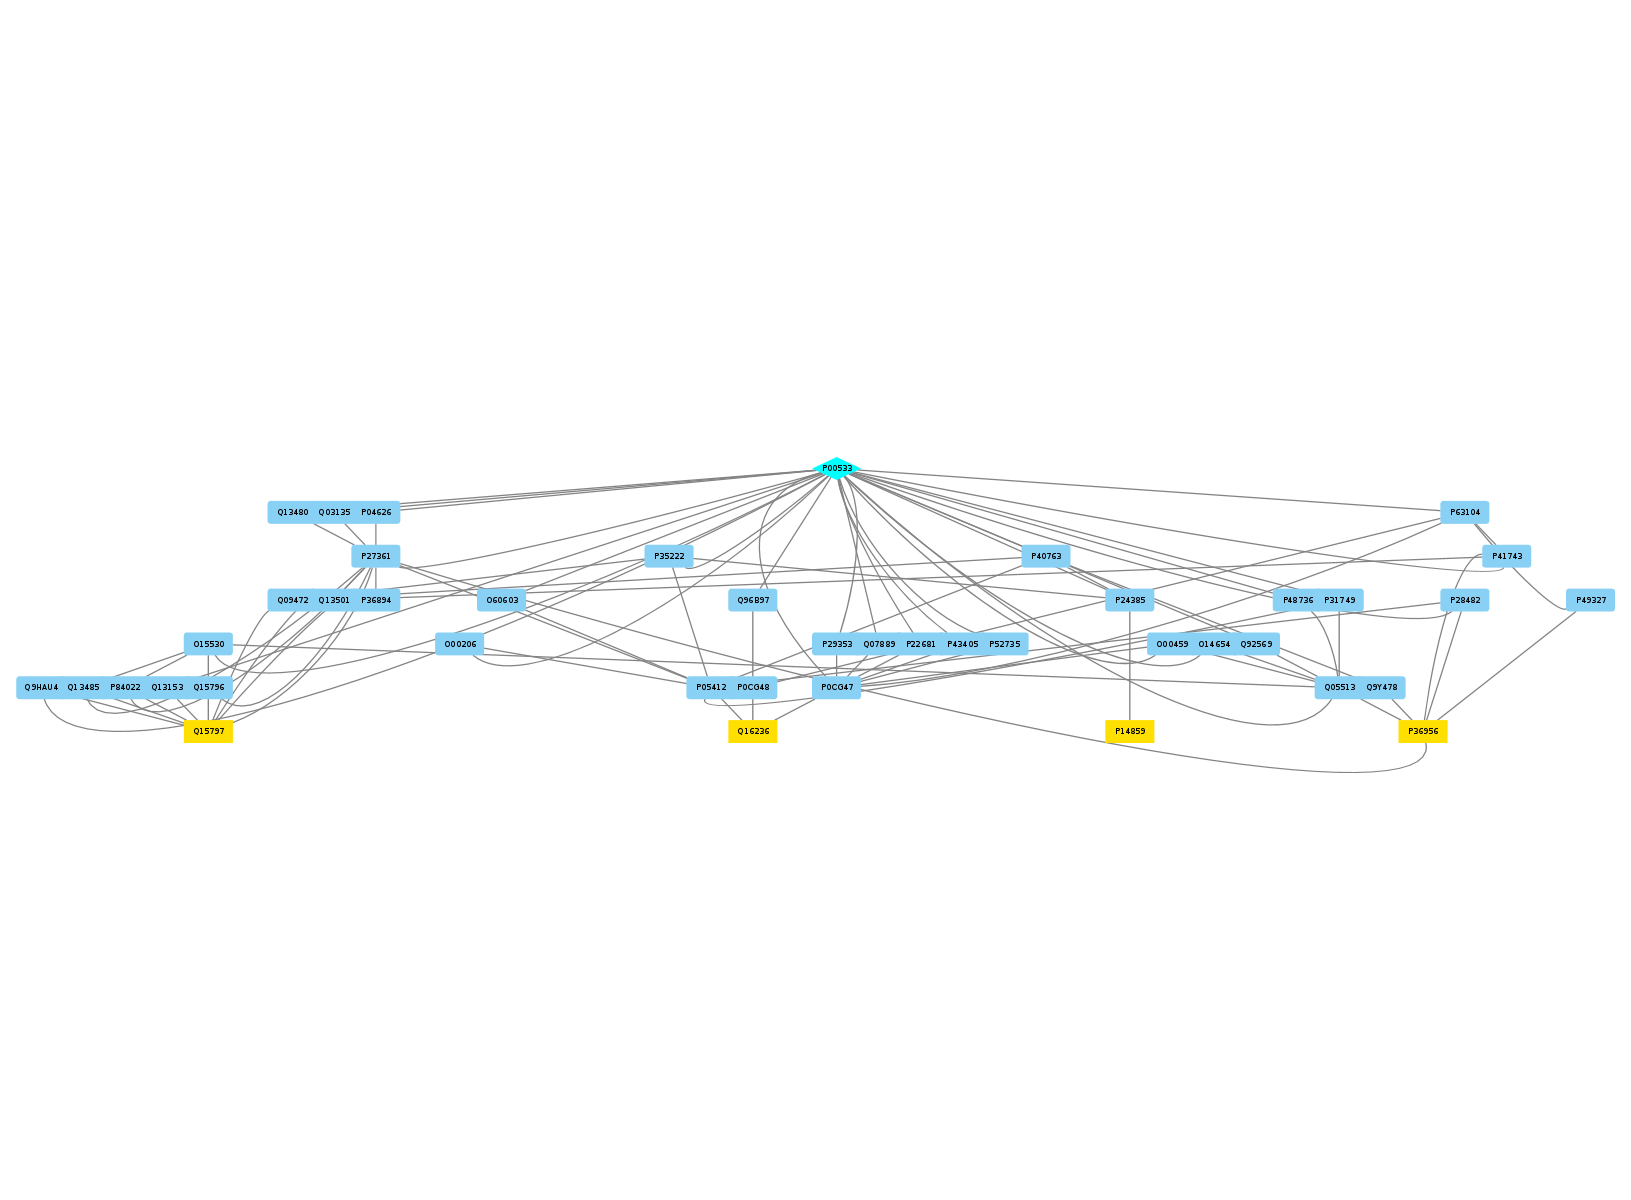

In [10]:
#png
subnetwork_image_png = subnetwork_ref.get_png()

from IPython.display import Image
Image(subnetwork_image_png)

## Show SVG image

run the following section only if there exists subnetwork_ref and subnetwork_view_ref.

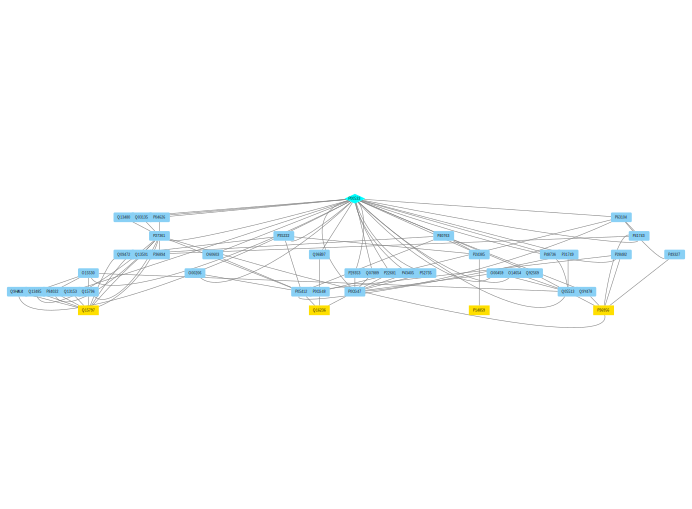

In [11]:
#svg
subnetwork_image_svg = subnetwork_ref.get_svg()

from IPython.display import SVG
SVG(subnetwork_image_svg)